En este notebook tratamos de usar el congelado generado desde el entrenamiento del DPDist e imprimir los valores en mapa de colores del DPDist sobre el modelo entrenado

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64


In [ ]:
import os
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.framework import graph_util

## CONGELANDO (NO EJECUTAR)

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False
sess3 = tf.InteractiveSession(config=config)

In [ ]:
tf.disable_eager_execution()
saver = tf.train.import_meta_graph('./model.ckpt.meta', import_scope='g1', clear_devices=True)
sess3.run(tf.global_variables_initializer())
sess3.run(tf.local_variables_initializer())
saver.restore(sess3, tf.train.latest_checkpoint(os.path.expanduser('./')))

output_node_names = 'g1/pc_compare/output1,g1/pc_compare/output2,g1/gpu_0/total_loss_pred'

# for fixing the bug of batch norm
gd = sess3.graph.as_graph_def()
for node in gd.node:            
    if node.op == 'RefSwitch':
        node.op = 'Switch'
        for index in xrange(len(node.input)):
            if 'moving_' in node.input[index]:
                node.input[index] = node.input[index] + '/read'
    elif node.op == 'AssignSub':
        node.op = 'Sub'
        if 'use_locking' in node.attr: del node.attr['use_locking']
    elif node.op == 'AssignAdd':
        node.op = 'Add'
        if 'use_locking' in node.attr: del node.attr['use_locking']

converted_graph_def = graph_util.convert_variables_to_constants(sess3, gd, output_node_names.split(","))
tf.train.write_graph(converted_graph_def, "./", "FREEZE_DPDIST.pb", as_text=False)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


'./FREEZE_DPDIST.pb'

# DPDIST

In [ ]:
def cargar_modelo_congelado(path):
  from tensorflow.python.platform import gfile
  model_path=path

  # read graph definition
  f = gfile.FastGFile(model_path, "rb")
  gd = graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())

  # fix nodes
  for node in graph_def.node:
      if node.op == 'RefSwitch':
          node.op = 'Switch'
          for index in xrange(len(node.input)):
              if 'moving_' in node.input[index]:
                  node.input[index] = node.input[index] + '/read'
      elif node.op == 'AssignSub':
          node.op = 'Sub'
          if 'use_locking' in node.attr: del node.attr['use_locking']

  # import graph into session
  with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    tf.train.write_graph(graph_def, './', 'good_frozen.pb', as_text=False)
    tf.train.write_graph(graph_def, './', 'good_frozen.pbtxt', as_text=True)

  return graph

In [ ]:
graph = cargar_modelo_congelado("./FREEZE_DPDIST.pb")

Instructions for updating:
Use tf.gfile.GFile.


In [ ]:
def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

In [ ]:
def crearsession(graph):
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  config.allow_soft_placement = True
  config.log_device_placement = False
  sess = tf.InteractiveSession(config=config, graph=graph)
  return sess

In [ ]:
def muestro_resimple(pointCloudA, pointCloudB, num_points=64, num_batches=16):
  #muestreo simple de datos
  pcA = pointCloudA[0:num_points*num_batches, :]
  pcB = pointCloudB[0:num_points*num_batches, :]
    #normalizacion
  pcA = pc_normalize(pcA)
  pcB = pc_normalize(pcB)

  return pcA, pcB


In [ ]:
def muestro_resimple2(pointCloudA, pointCloudB, num_points=64, num_batches=16):
  #muestreo simple de datos
  pcA = pointCloudA[0:num_points*num_batches, :]
  pcB = pointCloudB[num_points*num_batches:int((num_points*num_batches)*2), :]
    #normalizacion
  pcA = pc_normalize(pcA)
  pcB = pc_normalize(pcB)

  return pcA, pcB


In [ ]:
def crear_inputs(pointCloudA, pointCloudB, num_points, num_batches):

  #inputs
  input1 = pointCloudA.reshape(num_batches, num_points, pcA.shape[1])
  input2 = pointCloudB.reshape(num_batches,  num_points ,pcB.shape[1])
  noise = np.zeros((num_batches, num_points, 3))

  return input1, input2, noise

In [ ]:
def DPDist(pointCloudA, pointCloudB, freeze_graph=graph, num_points=64, num_batches=16):

  input_1, input_2, noise = crear_inputs(pointCloudA, pointCloudB, num_points, num_batches)

  sess=crearsession(graph)

  pred_AB=0
  pred_BA =0
  ## NOW the complete graph with values has been restored
  pred_AB = (graph.get_tensor_by_name('g1/pc_compare/output1:0'))
  pred_BA = (graph.get_tensor_by_name('g1/pc_compare/output2:0'))
  loss = (graph.get_tensor_by_name('g1/gpu_0/loss_pred:0'))
  ## Let's feed the images to the input placeholders
  x1= graph.get_tensor_by_name('g1/input1:0')
  x2= graph.get_tensor_by_name('g1/input2:0')
  x3= graph.get_tensor_by_name("g1/add_noise:0")
  #y_test_images = np.zeros((1, 2))
  #sess= tf.Session(graph=graph)
  ### Creating the feed_dict that is required to be fed to calculate y_pred 
  feed_dict_testing = {}
  feed_dict_testing = {x1: input_1, x2: input_2,  x3: noise}
  resultAB =sess.run(pred_AB, feed_dict=feed_dict_testing)
  resultBA=sess.run(pred_BA, feed_dict=feed_dict_testing)

  #DPDist entre nubes
  resultAB_0 = resultAB[:,:,:,0]
  resultBA_0 = resultBA[:,:,:,0]  
  resultAB_0 = resultAB_0.reshape(1024)
  resultBA_0 = resultBA_0.reshape(1024)
  dist_pcA_pcB=((1/pointCloudA.shape[0])*np.sum(resultAB))+((1/pointCloudB.shape[0])*np.sum(resultBA))


  return resultAB_0, resultBA_0, dist_pcA_pcB

In [ ]:
def plottear_DPDist(DistAB, DistBA, pcA, pcB):
  from matplotlib import pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D

  fig = plt.figure(figsize=(40,15))
  ax = fig.add_subplot(1, 3, 3, projection='3d')

  c = DistAB.reshape(1024)
  c= c[0:512]
  color_map = plt.get_cmap('jet')
  scatter_plot = ax.scatter3D(pcB[0:512,0], pcB[0:512,1], pcB[0:512,2], s=100, c=c, cmap = color_map)
  #scatter_plot2 = ax.scatter3D(pcA1024[:,0], pcA1024[:,1], pcA1024[:,2], c='blue', s=100, cmap = color_map)
  plt.colorbar(scatter_plot)
  
  # Show plot

  plt.show()

##Prueba con dos nubes

In [ ]:
pcA=np.loadtxt('../../data/modelnet40_normal_resampled/airplane/airplane_0008.txt', delimiter=',', usecols=(0,1,2))
pcB=np.loadtxt('../../data/modelnet40_normal_resampled/airplane/airplane_0008.txt', delimiter=',', usecols=(0,1,2))


In [ ]:
pcA, pcB = muestro_resimple(pcA, pcB)

In [ ]:
DistAB, DistBA, DPDistPCA_PCB=DPDist(pcA, pcB )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
DPDistPCA_PCB

0.031746286898851395

In [ ]:
pcA=np.loadtxt('../../data/modelnet40_normal_resampled/airplane/airplane_0008.txt', delimiter=',', usecols=(0,1,2))
pcB=np.loadtxt('../../data/modelnet40_normal_resampled/airplane/airplane_0008.txt', delimiter=',', usecols=(0,1,2))


In [ ]:
pcA, pcB = muestro_resimple2(pcA, pcB)

In [ ]:
DistAB, DistBA, DPDistPCA_PCB=DPDist(pcA, pcB)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
DPDistPCA_PCB

0.056394562125205994

In [ ]:
DPDistPCA_PCB

0.056394562125205994

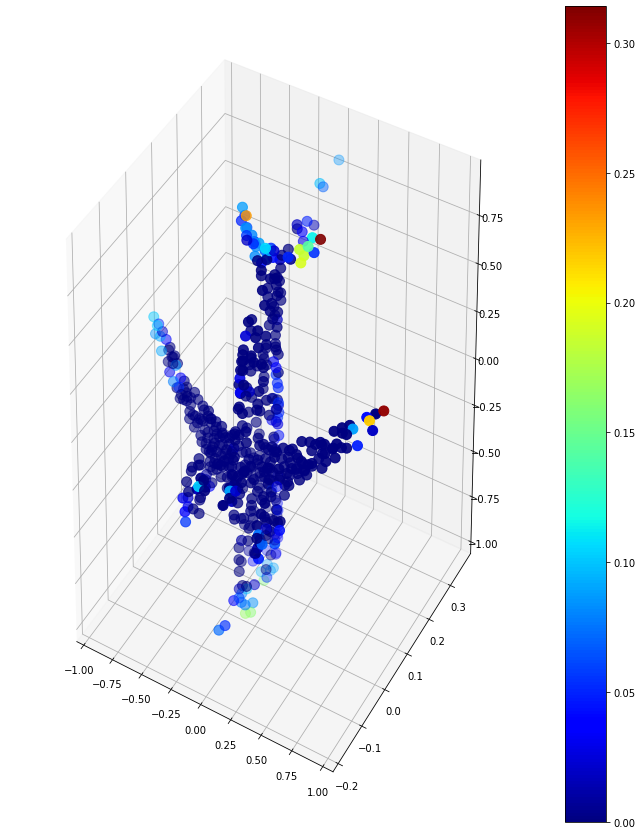

In [ ]:
plottear_DPDist(DistAB, DistBA, pcA, pcB)

#DATASET

##Funciones de Rotación

In [ ]:
def X_axis_rotation_matrix(theta):
    return np.array([[1,             0,              0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta),  np.cos(theta)]])

In [ ]:
def Y_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),  0,  np.sin(theta)],
                     [0,              1,              0],
                     [-np.sin(theta), 0,  np.cos(theta)]])

In [ ]:
def Z_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),   -np.sin(theta),    0],
                     [np.sin(theta),    np.cos(theta),    0],
                     [0,                0,                1]])

#Funciones de meustreo y normalización.

In [ ]:
def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    #centroid = np.mean(pc)
    #print(centroid.shape)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    #m = np.max(np.sqrt(np.sum(pc**2)))
    pc = pc / m
    return pc

In [ ]:
def muestro_resimple(pointCloudA, pointCloudB, num_points=64, num_batches=16, isNormalized=True):
  #muestreo simple de datos
  pcA = pointCloudA[0:num_points*num_batches, :]
  pcB = pointCloudB[0:num_points*num_batches, :]
    #normalizacion
  if (isNormalized == False):  
    pcA = pc_normalize(pcA)
    pcB = pc_normalize(pcB)

  return pcA, pcB


#Cargar modelo

In [ ]:
ptts = np.loadtxt('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/data/table/table_0008.txt', delimiter=',', usecols=(0,1,2))

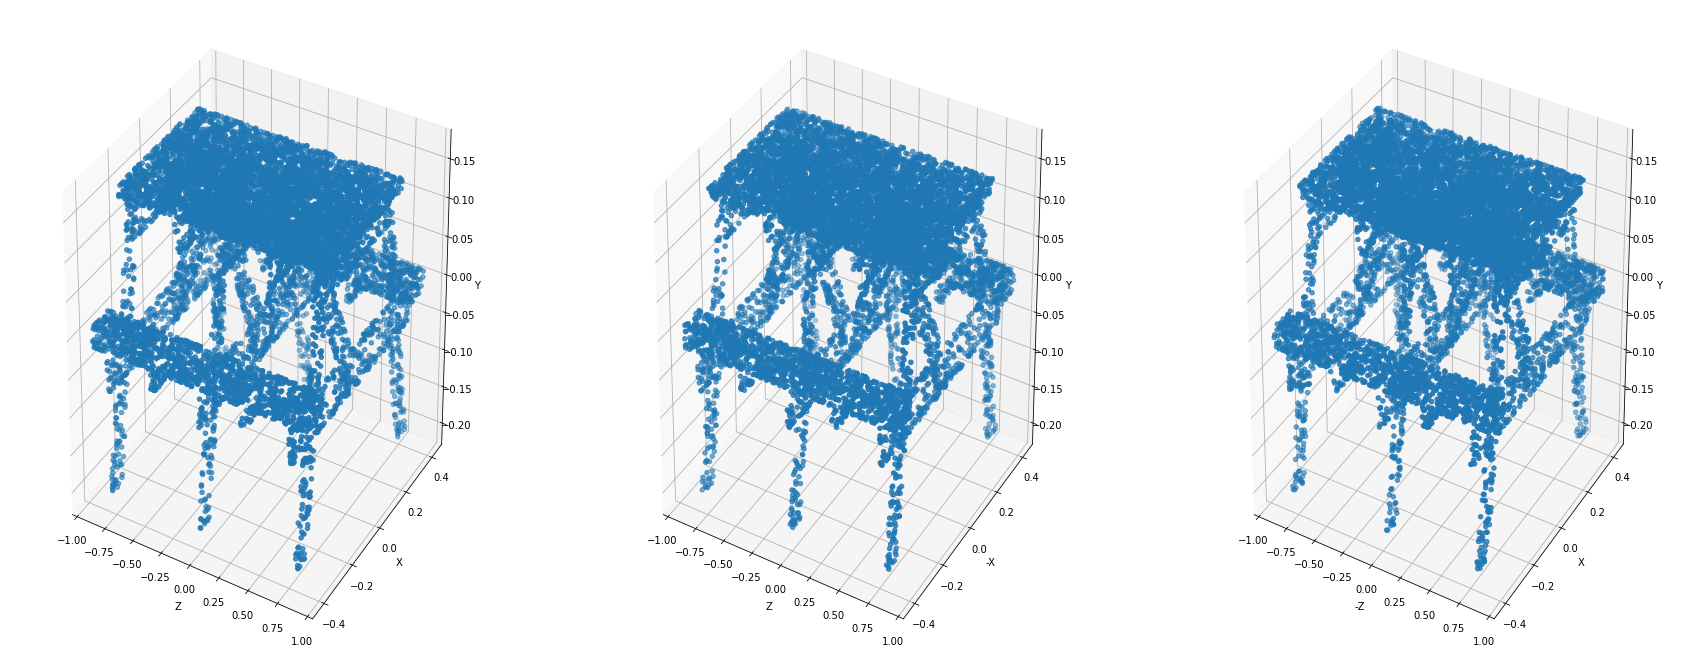

In [ ]:
fig = plt.figure(figsize=(30,12))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = ptts[:,0]
Y = ptts[:,1]
Z = ptts[:,2]

ax.scatter3D(Z,X,Y)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')


ax = fig.add_subplot(1, 3, 2, projection='3d')
X = ptts[:,0]
Y = ptts[:,1]
Z = ptts[:,2]

ax.scatter3D(Z,-X,Y)
ax.set_xlabel('Z')
ax.set_ylabel('-X')
ax.set_zlabel('Y')


ax = fig.add_subplot(1, 3, 3, projection='3d')
X = ptts[:,0]
Y = ptts[:,1]
Z = ptts[:,2]
ax.scatter3D(-Z,X,Y)
ax.set_xlabel('-Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')

plt.show()

#Muestreo de la nube de puntos

In [ ]:
#Retorna nube normalizada y centrada
ptts,_ = muestro_resimple(ptts,ptts)

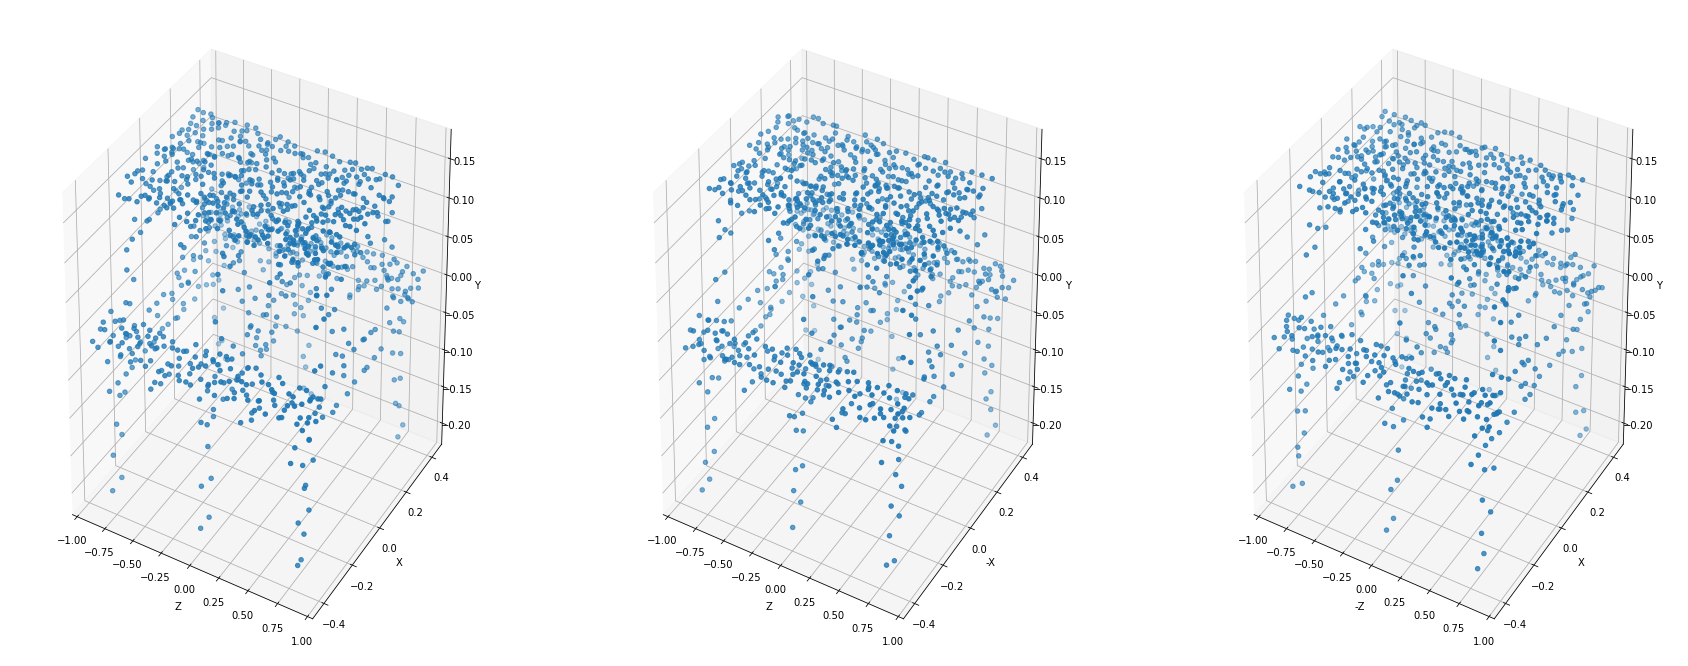

In [ ]:
fig = plt.figure(figsize=(30,12))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = ptts[:,0]
Y = ptts[:,1]
Z = ptts[:,2]

ax.scatter3D(Z,X,Y)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')


ax = fig.add_subplot(1, 3, 2, projection='3d')
X = ptts[:,0]
Y = ptts[:,1]
Z = ptts[:,2]

ax.scatter3D(Z,-X,Y)
ax.set_xlabel('Z')
ax.set_ylabel('-X')
ax.set_zlabel('Y')


ax = fig.add_subplot(1, 3, 3, projection='3d')
X = ptts[:,0]
Y = ptts[:,1]
Z = ptts[:,2]
ax.scatter3D(-Z,X,Y)
ax.set_xlabel('-Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')

plt.show()

# Generación del Dataset

In [ ]:
modelos=[]
angulos=[]
final_angle = np.pi*2

#Se recomienda revisar la distancia entre ángulos en caso de que algo no funcione.

for angle_x in np.arange(0,final_angle,0.1): #Cogí pasos de 0.1 radianes porque si no se explota otra vez :(
  for angle_y in np.arange(0,final_angle,0.1):
    for angle_z in np.arange(0,final_angle,0.1):

      modelo_rotado = np.dot(X_axis_rotation_matrix(angle_x),ptts.T).T
      modelo_rotado = np.dot(Y_axis_rotation_matrix(angle_y),modelo_rotado.T).T
      modelo_rotado = np.dot(Z_axis_rotation_matrix(angle_z),modelo_rotado.T).T

      modelos.append(modelo_rotado)
      angulos.append([angle_x, angle_y, angle_z])

print(len(modelos))
print(len(angulos))

250047
250047


In [ ]:

DpdistList = []
for i in range(10):
  DistAB, DistBA, DPDistAB=DPDist(modelos[0], modelos[i])
  DpdistList.append(DPDist) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
def createList(n):
    lst = []
    for i in range(n+1):
        lst.append(i)
    return(lst)

lista=createList(9)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

TypeError: ignored

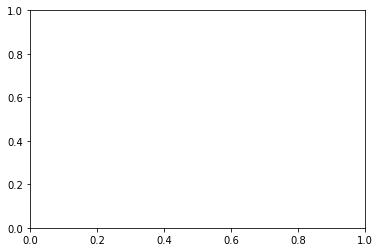

In [ ]:

plt.plot(DpdistList, lista)

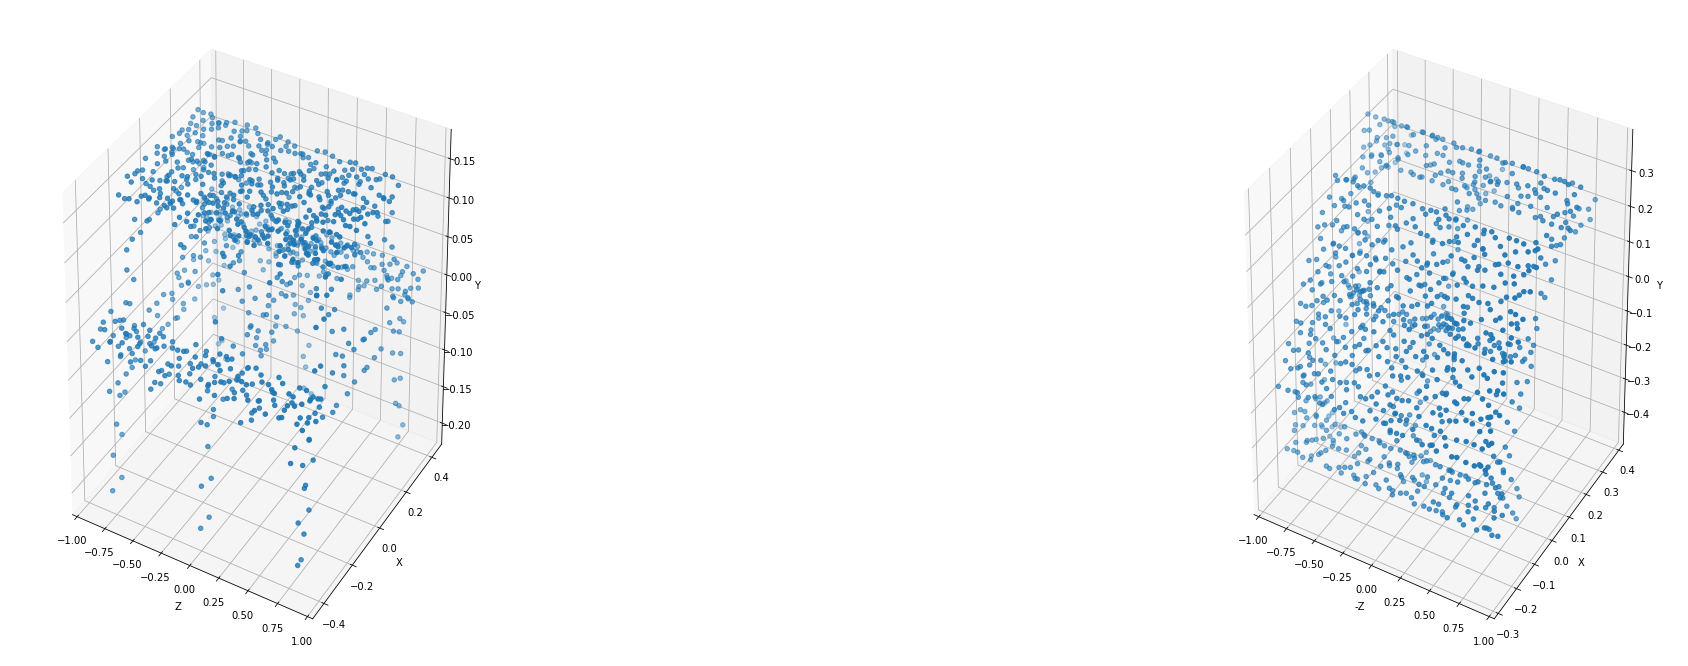

In [ ]:
fig = plt.figure(figsize=(30,12))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = modelos[0] [:,0]
Y = modelos[0] [:,1]
Z = modelos[0] [:,2]

ax.scatter3D(Z,X,Y)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')





ax = fig.add_subplot(1, 3, 3, projection='3d')
X = modelos[10] [:,0]
Y = modelos[10] [:,1]
Z = modelos[10] [:,2]
ax.scatter3D(-Z,X,Y)
ax.set_xlabel('-Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')

plt.show()

In [ ]:
DistAB, DistBA, DPDistAB=DPDist(modelos[0], modelos[54])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
DistAB[:10]

array([0.        , 0.24120621, 0.23391564, 0.12980533, 0.1384421 ,
       0.19132309, 0.18863082, 0.        , 0.        , 0.3321888 ],
      dtype=float32)

In [ ]:
DPDistAB

0.22020359337329865

In [ ]:
np.mean(DistAB)

0.10438138

In [ ]:
DistAB, DistBA, DPDistAB=DPDist(modelos[0], pcA)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
DPDistAB

0.056394562125205994

In [ ]:
np.mean(DistAB)

0.021182857

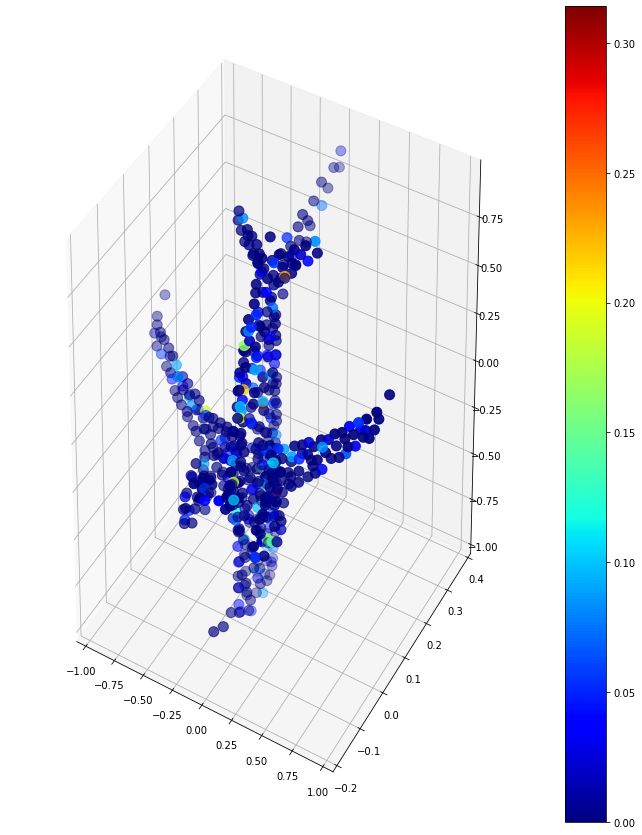

In [ ]:
plottear_DPDist(DistAB, DistBA,  modelos[20], pcA)

In [ ]:
DistAB[0:20]

array([0.        , 0.08410617, 0.        , 0.        , 0.02748148,
       0.        , 0.        , 0.        , 0.04973138, 0.        ,
       0.        , 0.        , 0.04187129, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [ ]:
DistBA[0:20]

array([0.        , 0.        , 0.1412508 , 0.06897359, 0.        ,
       0.05936465, 0.        , 0.        , 0.2539775 , 0.24679483,
       0.        , 0.        , 0.124518  , 0.01577786, 0.0281997 ,
       0.        , 0.        , 0.        , 0.        , 0.0561633 ],
      dtype=float32)

In [ ]:
l=[]
for i in range(len(DistAB)):
  if(DistAB[i]==0):
    
    l.append(i)
print(len(l))

684
